<center><h1>IMAGE CLASSIFICATION MODEL</h1>
<h3>(Building, Forest, Glacier, Mountain, Sea, Street)</h3></center>

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.models import model_from_json
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History
from keras.utils import plot_model
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import initializers
from PIL import Image
import numpy as np

# Fine-tuning transfer learning with VGG16 pretrained model

In [2]:
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

In [3]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable=True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable=False


for layer in conv_base.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [5]:
initializer = tf.keras.initializers.HeUniform()

In [6]:
model1 = Sequential()

model1.add(conv_base)
model1.add(Flatten())
model1.add(Dense(512, activation='relu', kernel_initializer=initializer))
model1.add(Dropout(0.5))
model1.add(BatchNormalization())
model1.add(Dense(6, activation='softmax'))

In [7]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                        

In [1]:
# plot_model(model1, show_shapes=True, show_layer_names=True)

# Data Preparation

In [12]:
batch_size=32

train_datagen = ImageDataGenerator(
                rescale=1./255,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    directory=r'C:\Users\HP\Image Recognition\Vehicle Image datatset\seg_train',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_gen = test_datagen.flow_from_directory(
    directory=r'C:\Users\HP\Image Recognition\Vehicle Image datatset\seg_test',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'    
)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# Model 1 Training

In [13]:
model1.compile(
            optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )

In [14]:
# mc = ModelCheckpoint("./model_checkpoint",
#                      monitor='val_loss',
#                     save_weights_only=True,
#                     save_best_only=True)

es1 = EarlyStopping(monitor="val_accuracy",
                    min_delta=0,
                    patience=10,
                    verbose=1,
                    mode="auto",
                    restore_best_weights=True)                   

In [16]:
history1 = model1.fit(train_gen,
         epochs=100,
         validation_data=validation_gen,
         callbacks=[es1])

Epoch 1/100
439/439 [==============================] - 127s 253ms/step - loss: 0.8251 - accuracy: 0.6917 - val_loss: 0.3849 - val_accuracy: 0.8620
Epoch 2/100
439/439 [==============================] - 99s 225ms/step - loss: 0.4678 - accuracy: 0.8348 - val_loss: 0.3397 - val_accuracy: 0.8797
Epoch 3/100
439/439 [==============================] - 99s 226ms/step - loss: 0.3931 - accuracy: 0.8650 - val_loss: 0.3062 - val_accuracy: 0.8923
Epoch 4/100
439/439 [==============================] - 97s 221ms/step - loss: 0.3463 - accuracy: 0.8799 - val_loss: 0.2909 - val_accuracy: 0.8997
Epoch 5/100
439/439 [==============================] - 97s 221ms/step - loss: 0.3216 - accuracy: 0.8913 - val_loss: 0.2796 - val_accuracy: 0.9013
Epoch 6/100
439/439 [==============================] - 98s 222ms/step - loss: 0.2923 - accuracy: 0.8981 - val_loss: 0.2692 - val_accuracy: 0.9050
Epoch 7/100
439/439 [==============================] - 106s 241ms/step - loss: 0.2759 - accuracy: 0.9054 - val_loss: 0.2733

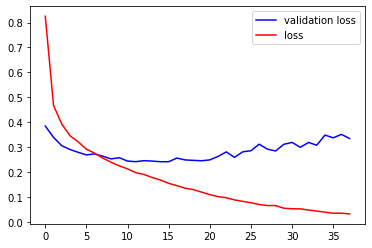

In [17]:
plt.plot(history1.history['val_loss'],color='blue', label='validation loss')
plt.plot(history1.history['loss'],color='red', label='loss')
plt.legend()
plt.show()

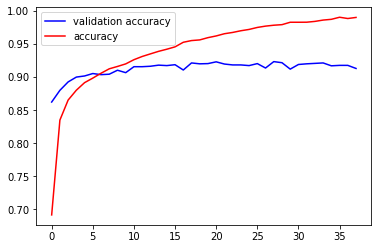

In [18]:
plt.plot(history1.history['val_accuracy'],color='blue', label='validation accuracy')
plt.plot(history1.history['accuracy'],color='red', label='accuracy')
plt.legend()
plt.show()

In [19]:
model1.evaluate(validation_gen)

94/94 [==============================] - 15s 155ms/step - loss: 0.2924 - accuracy: 0.9230


[0.2924451231956482, 0.9229999780654907]

In [41]:
# serialize model to JSON
model_json = model1.to_json()
with open("model1_new.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model1.save_weights("model1_new.h5")
print("Saved model to disk")


Saved model to disk


In [12]:
# history = model.fit(train_gen,
#          epochs=100,
#          validation_data=validation_gen,
#          callbacks=[es, mc], initial_epoch=20)

In [48]:
# load json and create model
json_file = open('model1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model1 = model_from_json(loaded_model_json)
# load weights into new model
model1.load_weights("model1.h5")
print("Loaded model from disk")

Loaded model from disk


In [49]:
model1.compile(
            optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )

# Model 2 

In [13]:
conv_base2 = ResNet50(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

In [14]:
model2 = Sequential()

model2.add(conv_base2)
model2.add(Flatten())
model2.add(Dense(256,activation='relu'))
model2.add(Dropout(0.5))
model2.add(BatchNormalization())
model2.add(Dense(6,activation='softmax'))

In [15]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               13107456  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (None, 6)                 1542      
                                                      

In [16]:
model2.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )

In [17]:
# mc2 = ModelCheckpoint("./model_checkpoint2",
#                      monitor='val_loss',
#                     save_weights_only=True,
#                     save_best_only=True)

es2 = EarlyStopping(monitor="val_loss",
                    min_delta=0,
                    patience=10,
                    verbose=1,
                    mode="auto",
                    restore_best_weights=True)   

In [18]:
history2 = model2.fit(train_gen,
         epochs=100,
         validation_data=validation_gen,
         callbacks=[es2])

Epoch 1/100
585/585 [==============================] - 274s 415ms/step - loss: 0.7692 - accuracy: 0.7287 - val_loss: 1.3258 - val_accuracy: 0.4500
Epoch 2/100
585/585 [==============================] - 233s 398ms/step - loss: 0.4039 - accuracy: 0.8627 - val_loss: 0.2643 - val_accuracy: 0.9093
Epoch 3/100
585/585 [==============================] - 235s 401ms/step - loss: 0.3287 - accuracy: 0.8893 - val_loss: 0.2378 - val_accuracy: 0.9203
Epoch 4/100
585/585 [==============================] - 212s 362ms/step - loss: 0.2864 - accuracy: 0.9016 - val_loss: 0.2195 - val_accuracy: 0.9253
Epoch 5/100
585/585 [==============================] - 190s 324ms/step - loss: 0.2507 - accuracy: 0.9156 - val_loss: 0.2118 - val_accuracy: 0.9267
Epoch 6/100
585/585 [==============================] - 190s 324ms/step - loss: 0.2346 - accuracy: 0.9194 - val_loss: 0.2037 - val_accuracy: 0.9313
Epoch 7/100
585/585 [==============================] - 190s 325ms/step - loss: 0.1991 - accuracy: 0.9283 - val_loss: 0

In [19]:
# # serialize model to JSON
# model_json = model.to_json()
# with open("model1.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model1.h5")
# print("Saved model to disk")

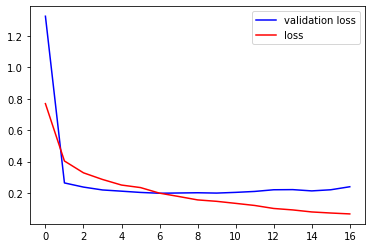

In [21]:
plt.plot(history2.history['val_loss'],color='blue', label='validation loss')
plt.plot(history2.history['loss'],color='red', label='loss')
plt.legend()
plt.show()

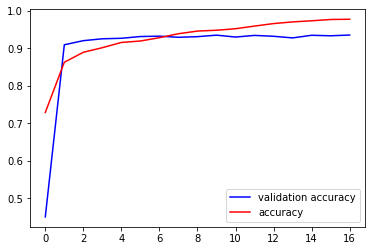

In [22]:
plt.plot(history2.history['val_accuracy'],color='blue', label='validation accuracy')
plt.plot(history2.history['accuracy'],color='red', label='accuracy')
plt.legend()
plt.show()

In [365]:
model2.evaluate(validation_gen)

125/125 [==============================] - 13s 99ms/step - loss: 0.1985 - accuracy: 0.9323


[0.1985456794500351, 0.9323333501815796]

In [51]:
model1.evaluate(validation_gen)

125/125 [==============================] - 15s 112ms/step - loss: 0.3098 - accuracy: 0.9220


[0.3098306953907013, 0.921999990940094]

In [31]:
train_gen.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [31]:
img_path = cv2.imread(r'C:\Users\HP\Image Recognition\Vehicle Image datatset\seg_pred\24308.jpg')

# img_path = cv2.imread(r'C:\Users\HP\Downloads\glacier.jpg')


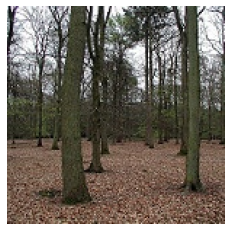

In [32]:
test_img = cv2.cvtColor(img_path, cv2.COLOR_BGR2RGB)

plt.imshow(test_img)
plt.axis("off")
plt.show()

In [33]:
test_input = test_img.reshape((1, 150, 150, 3))

In [536]:
model2.predict(test_input)

1/1 [==============================] - 0s 38ms/step


array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        8.8969964e-32, 0.0000000e+00]], dtype=float32)

In [34]:
model1.predict(test_input)

1/1 [==============================] - 0s 35ms/step


array([[0., 1., 0., 0., 0., 0.]], dtype=float32)

In [40]:
image = Image.open(r'C:\Users\HP\Downloads\glacier2.jpg')
image = np.array(image)
test_input=np.array(tf.image.resize(image, (150, 150),  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)).reshape((1, 150, 150, 3))

model1.predict(test_input)

1/1 [==============================] - 0s 30ms/step


array([[0.00000000e+00, 1.09964026e-13, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 1.14816640e-34]], dtype=float32)